In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import numpy as np
import os
import string
import requests
import io
import nltk

from zipfile import ZipFile
from sklearn.feature_extraction.text import TfidfVectorizer

/Users/atsushi.hara/.anyenv/envs/pyenv/versions/anaconda3-5.0.1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/atsushi.hara/.anyenv/envs/pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
sess = tf.Session()

In [3]:
batch_size = 200
max_features = 1000

# Data formatting

In [4]:
save_file_name = 'temp_spam_data.csv'

if os.path.isfile(save_file_name):
    text_data = []
    with open(save_file_name, 'r') as temp_output_file:
        reader = csv.reader(temp_output_file)
        for row in reader:
            text_data.append(row)
else:
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/' \
              '00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    text_data = file.decode()
    text_data = text_data.encode('ascii', errors='ignore')
    text_data = text_data.decode().split('\n')
    text_data = [x.split('\t') for x in text_data if len(x)>=1]
    
    with open(save_file_name, 'w') as temp_output_file:
        writer = csv.writer(temp_output_file)
        writer.writerows(text_data)
        
texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]

In [5]:
# Convert 'spam' label to 1, and 'ham' label to 0
target = [1. if x=='spam' else 0. for x in target]

In [6]:
# Normalize text data
texts = [x.lower() for x in texts]
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]
texts = [''.join(c for c in x if c not in '0123456789') for x in texts]
texts = [' '.join(x.split()) for x in texts]

# Creating features

In [7]:
def tokenizer(text):
    words = nltk.word_tokenize(text)
    return words

tfidf = TfidfVectorizer(tokenizer=tokenizer, stop_words='english', max_features=max_features)
sparse_tfidf_texts = tfidf.fit_transform(texts)

# if you had a Lookup Error in this cell, maybe that occurs because you don't have corpus for nltk.
# Execute below download code.
# nltk.download()

In [8]:
train_indices = np.random.choice(sparse_tfidf_texts.shape[0],
                                 round(0.8*sparse_tfidf_texts.shape[0]),
                                 replace=False)
test_indices = np.array(list(set(range(sparse_tfidf_texts.shape[0])) -
                             set(train_indices)))

texts_train = sparse_tfidf_texts[train_indices]
texts_test = sparse_tfidf_texts[test_indices]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_indices])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_indices])

# Modeling

In [9]:
A = tf.Variable(tf.random_normal(shape=[max_features, 1]))
B = tf.Variable(tf.random_normal(shape=[1,1]))

x_data = tf.placeholder(shape=[None, max_features], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

In [10]:
model_output = tf.add(tf.matmul(x_data, A), B)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))

In [11]:
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

In [12]:
opt = tf.train.GradientDescentOptimizer(0.0025)
train_step = opt.minimize(loss)

init = tf.global_variables_initializer()
sess.run(init)

In [13]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []

for i in range(10000):
    rand_index = np.random.choice(texts_train.shape[0], size=batch_size)
    rand_x = texts_train[rand_index].todense()
    rand_y = np.transpose([target_train[rand_index]])
    
    fd = {
        x_data: rand_x,
        y_target: rand_y,
    }
    sess.run(train_step, feed_dict=fd)
    
    if (i+1)%100 == 0:
        i_data.append(i+1)
        train_loss_temp = sess.run(loss, feed_dict=fd)
        train_loss.append(train_loss_temp)
        
        train_acc_temp = sess.run(accuracy, feed_dict=fd)
        train_acc.append(train_acc_temp)
        
        test_fd = {
            x_data: texts_test.todense(),
            y_target: np.transpose([target_test]),
        }
        test_loss_temp = sess.run(loss, feed_dict=test_fd)
        test_loss.append(test_loss_temp)
        
        test_acc_temp = sess.run(accuracy, feed_dict=test_fd)
        test_acc.append(test_acc_temp)
        
        if (i+1)%500 == 0:
            acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
            acc_and_loss = [np.round(x, 2) for x in acc_and_loss]
            print('Generation # {}. Train Loss (Test Loss): {:.2f} ({:.2f}). Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

Generation # 500. Train Loss (Test Loss): 1.72 (1.81). Train Acc (Test Acc): 0.22 (0.16)
Generation # 1000. Train Loss (Test Loss): 1.29 (1.30). Train Acc (Test Acc): 0.24 (0.25)
Generation # 1500. Train Loss (Test Loss): 0.99 (0.97). Train Acc (Test Acc): 0.34 (0.37)
Generation # 2000. Train Loss (Test Loss): 0.77 (0.77). Train Acc (Test Acc): 0.54 (0.53)
Generation # 2500. Train Loss (Test Loss): 0.69 (0.66). Train Acc (Test Acc): 0.62 (0.63)
Generation # 3000. Train Loss (Test Loss): 0.54 (0.59). Train Acc (Test Acc): 0.77 (0.71)
Generation # 3500. Train Loss (Test Loss): 0.47 (0.55). Train Acc (Test Acc): 0.78 (0.75)
Generation # 4000. Train Loss (Test Loss): 0.47 (0.52). Train Acc (Test Acc): 0.79 (0.78)
Generation # 4500. Train Loss (Test Loss): 0.49 (0.50). Train Acc (Test Acc): 0.82 (0.79)
Generation # 5000. Train Loss (Test Loss): 0.46 (0.49). Train Acc (Test Acc): 0.84 (0.80)
Generation # 5500. Train Loss (Test Loss): 0.52 (0.48). Train Acc (Test Acc): 0.80 (0.81)
Generation 

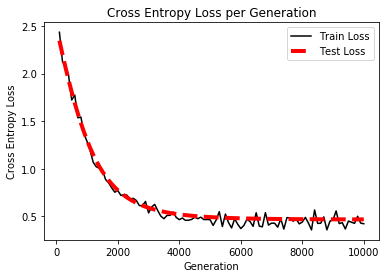

In [14]:
plt.plot(i_data, train_loss, 'k-', label='Train Loss')
plt.plot(i_data, test_loss, 'r--', label='Test Loss', linewidth=4)
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

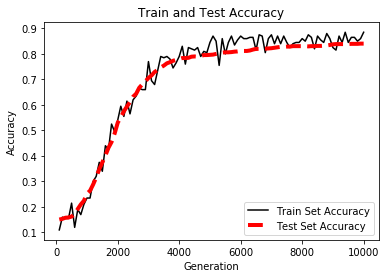

In [15]:
plt.plot(i_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accuracy', linewidth=4)
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()